## NLP with Disaster Tweets. Real or Not?

### Kaggle machine learning competitions.   
https://www.kaggle.com/c/nlp-getting-started

### __1__. Imports

In [1]:
import numpy as np 
import pandas as pd
import re
import string
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

In [2]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

In [3]:
#!pip install spacy
#!python -m spacy download en

In [4]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

import spacy
import en_core_web_sm

In [5]:
spacy.__version__

'2.3.2'

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [7]:
import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.figsize': (12,6)})
matplotlib.rcParams["axes.grid"] = True

In [8]:
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_palette('muted')

### __2__. Data Loading and Analysis

In [9]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [10]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [12]:
# Train Data Missing
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [13]:
# Test Data Missing
test_df.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [14]:
# Example of what is NOT a disaster tweet.
train_df[train_df["target"] == 0]["text"].values[1]

'I love fruits'

In [15]:
# Example of what is a disaster tweet.
train_df[train_df["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

In [16]:
train_df = train_df.drop(['id','keyword','location'],axis=1)
test_df  = test_df.drop(['id','keyword','location'],axis=1)
train_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [17]:
from wordcloud import WordCloud, STOPWORDS
STOPWORDS.add('http')
STOPWORDS.add('https')

def Plot_world(text):
    comment_words = ' '
    stopwords = set(STOPWORDS) 
    
    for val in text: 
        # typecaste each val to string 
        val = str(val) 
        # split the value 
        tokens = val.split() 
        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        for words in tokens: 
            comment_words = comment_words + words + ' '

    wordcloud = WordCloud(width = 6000, height = 3000, 
                    background_color ='black', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (16, 6), facecolor = 'k', edgecolor = 'k' ) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

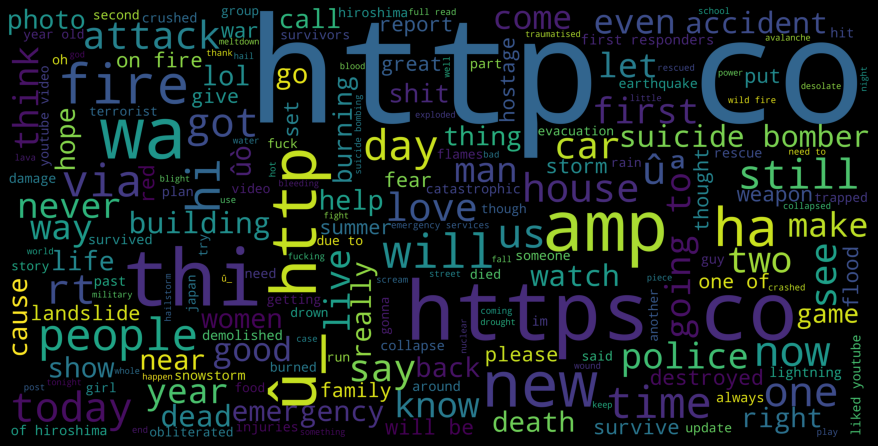

In [18]:
text = test_df.text.values
Plot_world(text)

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


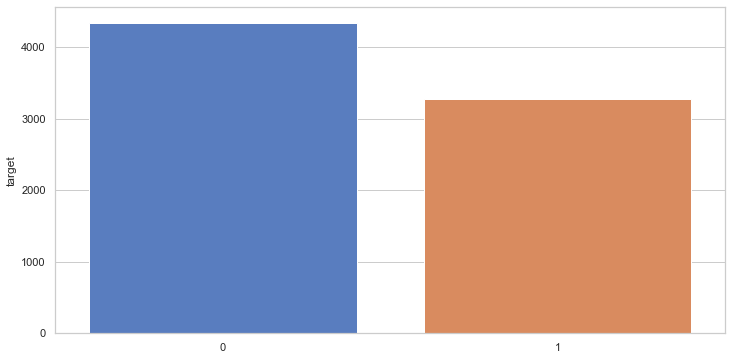

In [22]:
sns.barplot(train_df['target'].value_counts().index,train_df['target'].value_counts())

### Text Preprocessing

- Изменение регистра
- Токенизация
- Удаление стоп-слов
- Стеммизация (процесс приведения слова к его корню/основе)
- Лемматизация (похожа на стеммизацию в том, что она приводит слово к его начальной форме, но с одним отличием: в данном случае корень слова будет существующим в языке словом. Например, слово "caring" прекратится в "care", а не "car", как в стеммизации)
- Векторизация

In [23]:
#!pip install normalise
import nltk
nltk.download('punkt')
nltk.download('brown')
nltk.download('names')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('stopwords')
from normalise import normalise

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\samia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\samia\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\samia\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\samia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\samia\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\samia\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[

In [24]:
# Remove all the punctuations, html tags, # tags, etc
def remove_punc(text):
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    lower_case = text.lower()
    tokens=word_tokenize(lower_case)
    return (" ".join(tokens)).strip()

In [25]:
example_text = "This movie is just not goed. 😔 @@shawn Titanic? #tragedy could have been prevented, Economic Times: Telegraph.co.uk Titanic tragedy could have been prevented... http://bet.ly/tuN2wx"
remove_punc(example_text)

'this movie is just not goed 😔 shawn titanic tragedy could have been prevented economic times telegraphcouk titanic tragedy could have been prevented'

In [26]:
def remove_emoji(tweet):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', tweet)

def clean(tweet): 
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)   
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
       
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')

    # Acronyms
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"mÌ¼sica", "music", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)    
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)    
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet)
    tweet = re.sub(r"Suruc", "Sanliurfa", tweet)   
    
    # Grouping same words without embeddings
    tweet = re.sub(r"Bestnaijamade", "bestnaijamade", tweet)
    tweet = re.sub(r"SOUDELOR", "Soudelor", tweet)
    
    return tweet

In [27]:
example_text = "This movie is just not goed. 😔 @@shawn Titanic? #tragedy could have been prevented, Economic Times: Telegraph.co.uk Titanic tragedy could have been prevented... http://bet.ly/tuN2wx"

In [28]:
nlp = en_core_web_sm.load()

customize_stop_words = ['not', 'just']
for w in customize_stop_words:
    nlp.vocab[w].is_stop = False

def spacy_token(text):
    text = re.sub('#', '', text)
    text = re.sub('@', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('http?://\S+|www\.\S+', '', text)
    text = clean(text)
    text = remove_emoji(text)
    
    doc = nlp(text)
    # -Пунктуация, -Стоп-слова, +Лемматизация
    tokens = [t.lemma_ for t in doc if (t.pos_ != 'PUNCT') & (not t.is_stop)]
    # Нормализация (в т.ч. исправление ошибок)
    #tokens = normalise(tokens, verbose=False)
    #return tokens
    return (" ".join(tokens)).strip()
spacy_token(example_text)

'movie just not goed   shawn Titanic tragedy prevent Economic Times Telegraph.co.uk titanic tragedy prevent'

In [29]:
train_df.iloc[2236:2237]['text'].apply(spacy_token).to_list()

['search powerful content improve business frustrate deluge quantithttps://t.co/64cymg1ltg']

In [30]:
#normalise(train_df.iloc[2236:2237]['text'])

In [31]:
#train = train_df.copy()
#train.loc[:,'text'] = train['text'].progress_apply(spacy_token)

In [32]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.8, 15):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [33]:
class TextImputer(BaseEstimator, TransformerMixin):
    def __init__(self, key, value):
        self.key = key
        self.value = value
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[self.key] = X[self.key].fillna(self.value)
        return X
    
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self._key = key
        """
        Text preprocessing transformer includes steps:
            1. Punctuation removal
            2. Stop words removal
            3. Lemmatization
            4. Text normalization            
        """
    def preprocess_text(self, text):
        text = re.sub('#', '', text)
        text = re.sub('\n', '', text)
        text = re.sub('http?://\S+|www\.\S+', '', text)
        text = clean(text)
        text = remove_emoji(text)
        
        doc = nlp(text)
        # -Пунктуация, -Стоп-слова, +Лемматизация
        tokens = [t.lemma_ for t in doc if (t.pos_ != 'PUNCT') & (not t.is_stop)]
        # Нормализация (в т.ч. исправление ошибок)
        #tokens = normalise(tokens, verbose=False)        
        return (" ".join(tokens)).strip()
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X.loc[:,(self._key)] = X[self._key].apply(self.preprocess_text)
        #X[self._key] = X[self._key].progress_apply(self.preprocess_text)
        
        return X[self._key]

In [34]:
import warnings
warnings.filterwarnings('ignore')

In [35]:
train_df["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [36]:
pipe_text = Pipeline([('imputer', TextImputer(key='text', value = '')),
                    ('preprocessor', TextPreprocessor(key='text')),
                    ('tfidf', TfidfVectorizer(analyzer="word")),
                     #('classifier', MultinomialNB(alpha=0.5)),
                    ('classifier', LogisticRegression(C=2.4)),
                    ])

In [37]:
X_train, X_val, y_train, y_val = train_test_split(train_df, train_df['target'], test_size=0.1, random_state=37)

In [38]:
#pipe_text.fit(X_train, y_train)
pipe_text.fit(train_df, train_df['target'])

Pipeline(memory=None,
         steps=[('imputer', TextImputer(key='text', value='')),
                ('preprocessor', TextPreprocessor(key=None)),
                ('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=N...
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=2.4, class_weight=None, dual=False,
                            

In [39]:
preds = pipe_text.predict(X_val)
probs = pipe_text.predict_proba(X_val)

In [40]:
pipe_text.score(X_val, y_val)

0.9238845144356955

In [41]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       443
           1       0.96      0.85      0.90       319

    accuracy                           0.92       762
   macro avg       0.93      0.91      0.92       762
weighted avg       0.93      0.92      0.92       762



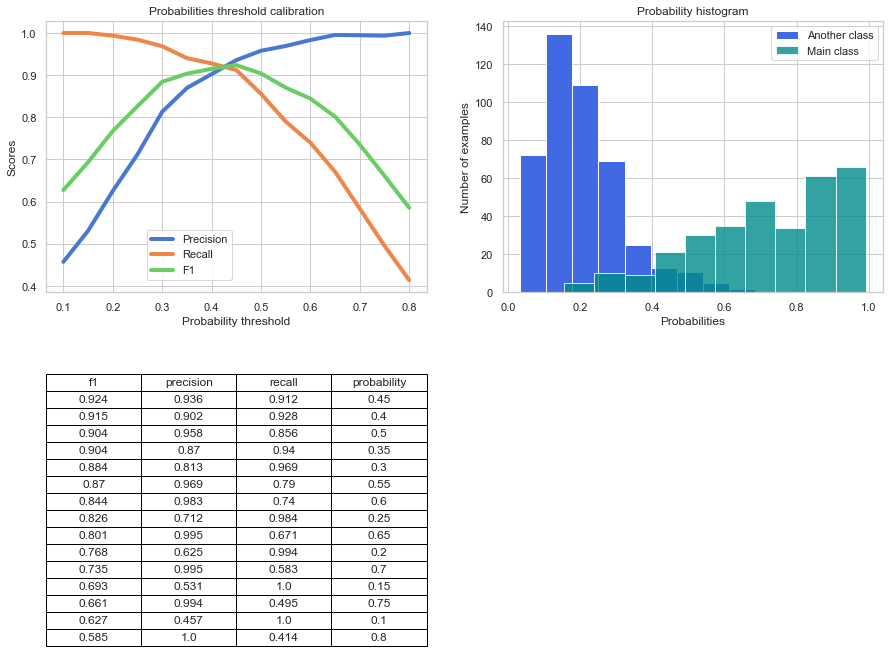

In [42]:
show_proba_calibration_plots(probs[:, 1], y_val.values)

In [43]:
def calc_pred(x):
    return np.array([1 if x >= 0.45 else 0 for x in x])

In [44]:
y_pred_ = calc_pred(probs[:, 1])

In [45]:
print(classification_report(y_val, y_pred_))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       443
           1       0.94      0.91      0.92       319

    accuracy                           0.94       762
   macro avg       0.94      0.93      0.94       762
weighted avg       0.94      0.94      0.94       762



In [46]:
new_text = ['Can you get Covid-19 through your eyes? Possibly. Should we all be wearing goggles? Probably not.']
dd = pd.DataFrame(data = {'text': new_text})

In [47]:
pipe_text.predict(dd)[0]

0

In [50]:
probs = pipe_text.predict_proba(test_df)
prediction = calc_pred(probs[:, 1])

In [51]:
submit_file= pd.read_csv('sample_submission.csv')
submit_file['target'] = prediction
submit_file.to_csv("submission.csv", index=False, header=True)

In [52]:
import dill
with open("model_nlp.dill", "wb") as f:
    dill.dump(pipe_text, f)